In [2]:
import numpy as np
import pandas as pd
import json as json
import re
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr


/Users/benmischeck/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/benmischeck/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define the map to convert expert ratings
rating_map = {
    "Not creative at all": 0,
    "Not novel at all (common / already exists)": 0,
    "Not useful at all (impractical / irrelevant)": 0,

    "Slightly creative": 0.25,
    "Slightly novel": 0.25,
    "Slightly useful": 0.25,

    "Moderately creative": 0.5,
    "Moderately novel": 0.5,
    "Moderately useful": 0.5,

    "Very creative": 0.75,
    "Very novel": 0.75,
    "Very useful": 0.75,

    "Extremely creative": 1,
    "Extremely novel (completely original)": 1,
    "Extremely useful (highly efficient / beneficial)": 1}

In [ ]:
# Import CAT results from Qualtrics
df_survey = pd.read_excel("XXX/CAT_1_results.xlsx")

# Rename to matching col names
df_survey = df_survey.rename(columns={"Response ID": "ResponseId"})

# Identify all participant generated ideas
idea_cols = [col for col in df_survey.columns if re.match(r"R_\w+_(c|n|u)", col)]

# Use RepsonseId as identifier and melt the dataframe
df_melt = df_survey.melt(id_vars=["ResponseId"], value_vars=idea_cols, var_name="idea_measurement", value_name="rating")

# Find measurment dimension 
df_melt[["Idea_ID", "Measurement"]] = df_melt["idea_measurement"].str.extract(r"(R_\w+)_(c|n|u)")

# Pivot new dataframe so each idea is stored in rwo 
df_pivot = df_melt.pivot_table(index=["Idea_ID", "Measurement"], columns="ResponseId", values="rating", aggfunc="first").reset_index()

# Create final dataframe
df_survey = df_pivot[["Idea_ID", "Measurement", "R_2fdR10tBemYxOk3", "R_8Ckqem1SpWpxZS1", "R_8JkIbXKkCr0VC99", "R_8QqhAmqbAms4xDX", "R_4X7f1muJE5PP7oC", "R_8B705usSidtje5b", "R_3tgoifSej9ZIDJC"]]
df_survey = df_survey.replace(rating_map)
display(df_survey)

/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_38609/1026427659.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_survey = df_survey.replace(rating_map)


ResponseId,Idea_ID,Measurement,R_2fdR10tBemYxOk3,R_8Ckqem1SpWpxZS1,R_8JkIbXKkCr0VC99,R_8QqhAmqbAms4xDX,R_4X7f1muJE5PP7oC,R_8B705usSidtje5b,R_3tgoifSej9ZIDJC
0,R_1VllX72TovsGQQP,c,0.75,0.75,0.00,0.50,0.00,0.75,0.75
1,R_1VllX72TovsGQQP,n,1.00,0.75,0.00,0.50,0.00,1.00,0.75
2,R_1VllX72TovsGQQP,u,0.75,0.75,0.50,0.75,0.25,0.25,0.25
3,R_1qDuAKmI1NSxncV,c,0.50,0.50,0.25,0.50,0.25,0.00,0.50
4,R_1qDuAKmI1NSxncV,n,0.50,0.50,0.00,0.75,0.25,0.00,0.50
...,...,...,...,...,...,...,...,...,...
309,R_8uCLXxXqRRRqE9o,n,0.75,0.75,0.00,0.50,0.50,0.50,0.75
310,R_8uCLXxXqRRRqE9o,u,0.50,0.75,0.25,0.25,0.00,0.00,0.25
311,R_8z7RTkoUIZjBwYx,c,0.75,0.50,0.00,0.75,0.50,0.00,0.25
312,R_8z7RTkoUIZjBwYx,n,0.75,0.50,0.00,1.00,0.50,0.00,0.25


In [ ]:
# Import CAT results from Qualtrics
df_chatgpt = pd.read_excel("XXXX/CAT_1_results.xlsx")

# Rename to matching col names
df_chatgpt = df_chatgpt.rename(columns={"Response ID": "ResponseId"})

# Identify all participant generated ideas
idea_cols = [col for col in df_chatgpt.columns if isinstance(col, str) and re.match(r"AI\d+_(c|n|u)", col)]

# Use RepsonseId as identifier and melt the dataframe
df_melt = df_chatgpt.melt(id_vars=["ResponseId"], value_vars=idea_cols, var_name="idea_measurement", value_name="rating")

# Find measurment dimension 
df_melt[["Idea_ID", "Measurement"]] = df_melt["idea_measurement"].str.extract(r"(AI\d+)_(c|n|u)")

# Pivot new dataframe so each idea is stored in rwo 
df_pivot = df_melt.pivot_table(index=["Idea_ID", "Measurement"], columns="ResponseId", values="rating", aggfunc="first").reset_index()

# Create final dataframe
df_chatgpt = df_pivot[["Idea_ID", "Measurement", "R_2fdR10tBemYxOk3", "R_8Ckqem1SpWpxZS1", "R_8JkIbXKkCr0VC99", "R_8QqhAmqbAms4xDX", "R_4X7f1muJE5PP7oC", "R_8B705usSidtje5b", "R_3tgoifSej9ZIDJC"]]
df_chatgpt = df_chatgpt.replace(rating_map)
display(df_chatgpt)

/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_38609/235823096.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_chatgpt = df_chatgpt.replace(rating_map)


ResponseId,Idea_ID,Measurement,R_2fdR10tBemYxOk3,R_8Ckqem1SpWpxZS1,R_8JkIbXKkCr0VC99,R_8QqhAmqbAms4xDX,R_4X7f1muJE5PP7oC,R_8B705usSidtje5b,R_3tgoifSej9ZIDJC
0,AI1,c,0.50,0.25,0.25,0.75,0.50,0.25,0.25
1,AI1,n,0.50,0.25,0.25,0.75,0.25,0.25,0.25
2,AI1,u,0.50,0.50,0.50,1.00,0.75,0.75,0.75
3,AI10,c,0.50,0.75,0.25,0.75,0.00,0.25,0.25
4,AI10,n,0.25,0.75,0.50,0.75,0.00,0.25,0.25
...,...,...,...,...,...,...,...,...,...
70,AI8,n,0.75,0.75,0.50,0.75,0.50,0.25,0.25
71,AI8,u,0.50,0.50,0.50,0.75,0.50,0.75,0.75
72,AI9,c,0.25,0.75,0.25,0.75,0.00,0.00,0.25
73,AI9,n,0.25,0.50,0.25,1.00,0.00,0.00,0.25


In [6]:
# Recombine both dataframe 
df_combined = pd.concat([df_survey, df_chatgpt], ignore_index=True)

# Define the expert cols
expert_cols = [
    "R_2fdR10tBemYxOk3",
    "R_8Ckqem1SpWpxZS1",
    "R_8JkIbXKkCr0VC99",
    "R_8QqhAmqbAms4xDX",
    "R_4X7f1muJE5PP7oC",
    "R_8B705usSidtje5b",
    "R_3tgoifSej9ZIDJC"
]

# Copy expert rating to new df
df_experts = df_combined[expert_cols].copy()

# Compute cronbach alpha
cronbach_alpha = pg.cronbach_alpha(data=df_experts)
print("Cronbach's alpha:", cronbach_alpha)

# drop N/A and prepare data for intra-class correlation
df_experts = df_experts.dropna()
df_long = df_experts.reset_index().melt(id_vars='index', 
                                               value_vars=expert_cols,
                                               var_name='rater',
                                               value_name='rating')

# Compute intra-class correlation
icc_result = pg.intraclass_corr(data=df_long, targets='index', raters='rater', ratings='rating')
print("Intraclass Correlation Coefficient:", icc_result)


Cronbach's alpha: (0.7969122036867955, array([0.765, 0.826]))
Intraclass Correlation Coefficient:     Type              Description       ICC         F  df1   df2  \
0   ICC1   Single raters absolute  0.270689  3.598101  379  2280   
1   ICC2     Single random raters  0.290108  4.879114  379  2274   
2   ICC3      Single fixed raters  0.356565  4.879114  379  2274   
3  ICC1k  Average raters absolute  0.722076  3.598101  379  2280   
4  ICC2k    Average random raters  0.740976  4.879114  379  2274   
5  ICC3k     Average fixed raters  0.795045  4.879114  379  2274   

            pval         CI95%  
0   4.866279e-79  [0.23, 0.31]  
1  3.304673e-126  [0.22, 0.36]  
2  3.304673e-126   [0.31, 0.4]  
3   4.866279e-79  [0.68, 0.76]  
4  3.304673e-126   [0.66, 0.8]  
5  3.304673e-126  [0.76, 0.83]  


In [7]:
# Create new dataframe with average ratings for eahc idea
df_survey['avg_expert_rating'] = df_survey[["R_2fdR10tBemYxOk3", "R_8Ckqem1SpWpxZS1", "R_8JkIbXKkCr0VC99", "R_8QqhAmqbAms4xDX", "R_4X7f1muJE5PP7oC", "R_8B705usSidtje5b", "R_3tgoifSej9ZIDJC"]].mean(axis=1)
df_survey = df_survey[['Idea_ID', 'Measurement', 'avg_expert_rating']]
df_survey = df_survey.pivot(index='Idea_ID', columns='Measurement', values='avg_expert_rating').reset_index()
df_survey.columns = ['Idea_ID', 'avg_creativity_rating', 'avg_novelty_rating', 'avg_usefulness_rating']

display(df_survey.head())


,Idea_ID,avg_creativity_rating,avg_novelty_rating,avg_usefulness_rating
0,R_1VllX72TovsGQQP,0.500000,0.571429,0.500000
1,R_1qDuAKmI1NSxncV,0.357143,0.357143,0.464286
2,R_20ZHsH9Y3Zhv6Z0,0.392857,0.285714,0.500000
3,R_20cuzY5RvsACUOx,0.392857,0.321429,0.607143
4,R_20pCSLhwpy6fYB6,0.678571,0.642857,0.392857


In [8]:
# Create new dataframe with average ratings for eahc idea
df_chatgpt['avg_expert_rating'] = df_chatgpt[["R_2fdR10tBemYxOk3", "R_8Ckqem1SpWpxZS1", "R_8JkIbXKkCr0VC99", "R_8QqhAmqbAms4xDX", "R_4X7f1muJE5PP7oC", "R_8B705usSidtje5b", "R_3tgoifSej9ZIDJC"]].mean(axis=1)
df_chatgpt = df_chatgpt[['Idea_ID', 'Measurement', 'avg_expert_rating']]
df_chatgpt = df_chatgpt.pivot(index='Idea_ID', columns='Measurement', values='avg_expert_rating').reset_index()
df_chatgpt.columns = ['Idea_ID', 'avg_creativity_rating', 'avg_novelty_rating', 'avg_usefulness_rating']

display(df_chatgpt.head())


,Idea_ID,avg_creativity_rating,avg_novelty_rating,avg_usefulness_rating
0,AI1,0.392857,0.357143,0.678571
1,AI10,0.392857,0.392857,0.785714
2,AI11,0.464286,0.464286,0.535714
3,AI12,0.428571,0.392857,0.714286
4,AI13,0.392857,0.357143,0.535714


In [ ]:
# import additional information about participants 
df_participants = pd.read_excel("XXXX/SurveyResults_clean.xlsx")
columns = ['Response ID', 'idea_elaboration', 'GroupAssignment', 'Task1_ChatGPT_Access', 'Task1_ChatGPT_Interaction', 'Task2_ChatGPT_Access', 'Task2_ChatGPT_Interaction', 'DAT_score', 'BusinessFamilarity', 'EngExp', 'ProfField', 'InnoMgmtExp', 'SustainabilityExp', 'GenAIExp', 'GenAIFrequency', 'Age', 'Gender']
df_participants = df_participants[columns]

df_ideas = pd.merge(df_survey, df_participants, left_on='Idea_ID', right_on='Response ID', how='left')
display(df_ideas.head())

,Idea_ID,avg_creativity_rating,avg_novelty_rating,avg_usefulness_rating,Response ID,idea_elaboration,GroupAssignment,Task1_ChatGPT_Access,Task1_ChatGPT_Interaction,Task2_ChatGPT_Access,...,DAT_score,BusinessFamilarity,EngExp,ProfField,InnoMgmtExp,SustainabilityExp,GenAIExp,GenAIFrequency,Age,Gender
0,R_1VllX72TovsGQQP,0.500000,0.571429,0.500000,R_1VllX72TovsGQQP,Delivery packaging waste is one of the main so...,Human_Human,0.0,0.0,0.0,...,77.098788,Somewhat familiar,Near-Native (C2),"Business, Economics, & Management",Minimal experience,Basic experience,Practical experience,Frequently (1-3x per week),25–34,Male
1,R_1qDuAKmI1NSxncV,0.357143,0.357143,0.464286,R_1qDuAKmI1NSxncV,Blue and green roofs. Especially in city’s it ...,Human_Human,0.0,0.0,0.0,...,76.592603,Slightly familiar,Advanced (C1),Education & Teaching,No experience,Basic experience,Basic experience,Daily or almost daily,25–34,Female
2,R_20ZHsH9Y3Zhv6Z0,0.392857,0.285714,0.500000,R_20ZHsH9Y3Zhv6Z0,Low-Flow Fixtures: Upgrade to low-flow faucets...,Human_Human/AI,0.0,0.0,1.0,...,76.814633,Slightly familiar,Advanced (C1),Law & Legal Studies,Minimal experience,Minimal experience,Minimal experience,Rarely (less than once month),45–54,Female
3,R_20cuzY5RvsACUOx,0.392857,0.321429,0.607143,R_20cuzY5RvsACUOx,A digital sustainability coach is an AI-based ...,Human/AI_Human,1.0,1.0,0.0,...,79.630301,Very familiar,Near-Native (C2),Natural Sciences,Minimal experience,Basic experience,Practical experience,Frequently (1-3x per week),25–34,Female
4,R_20pCSLhwpy6fYB6,0.678571,0.642857,0.392857,R_20pCSLhwpy6fYB6,Creating a countrywide deposit system for wine...,Human_Human/AI,0.0,0.0,1.0,...,82.117404,Somewhat familiar,Near-Native (C2),Other,No experience,Practical experience,Practical experience,Frequently (1-3x per week),55–64,Female


In [10]:
# dummy encoding of all relevant control variables
df_ideas['BusinessFamiliarity_High'] = df_ideas['BusinessFamilarity'].apply(lambda x: 1 if x in ['Very familiar', 'Extremely familiar'] else 0)
df_ideas['EngExp_High'] = df_ideas['EngExp'].apply(lambda x: 1 if x in ['Near-Native (C2)', 'Native'] else 0)
df_ideas['ProfField_Business'] = df_ideas['ProfField'].apply(lambda x: 1 if x in ['Business, Economics, & Management'] else 0)
df_ideas['InnoMgmtExp_High'] = df_ideas['InnoMgmtExp'].apply(lambda x: 1 if x in ['Practical experience', 'Professional experience'] else 0)
df_ideas['SustainabilityExp_High'] = df_ideas['SustainabilityExp'].apply(lambda x: 1 if x in ['Practical experience', 'Professional experience'] else 0)
df_ideas['GenAIExp_High'] = df_ideas['GenAIExp'].apply(lambda x: 1 if x in ['Practical experience', 'Professional experience'] else 0)
df_ideas['GenAIFrequency_High'] = df_ideas['GenAIFrequency'].apply(lambda x: 1 if x in ['Daily or almost daily', 'Frequently (1-3x per week)'] else 0)
df_ideas['Age_35+'] = df_ideas['Age'].apply(lambda x: 1 if x in ['35–44', '45-54', '55-64', '65 or older'] else 0)
df_ideas['Gender_Male'] = df_ideas['Gender'].apply(lambda x: 1 if x in ['Male'] else 0)

# standardize DAT score using z score
scaler = StandardScaler()
df_ideas['DAT_score_standardized'] = scaler.fit_transform(df_ideas[['DAT_score']])

display(df_ideas.head())

,Idea_ID,avg_creativity_rating,avg_novelty_rating,avg_usefulness_rating,Response ID,idea_elaboration,GroupAssignment,Task1_ChatGPT_Access,Task1_ChatGPT_Interaction,Task2_ChatGPT_Access,...,BusinessFamiliarity_High,EngExp_High,ProfField_Business,InnoMgmtExp_High,SustainabilityExp_High,GenAIExp_High,GenAIFrequency_High,Age_35+,Gender_Male,DAT_score_standardized
0,R_1VllX72TovsGQQP,0.500000,0.571429,0.500000,R_1VllX72TovsGQQP,Delivery packaging waste is one of the main so...,Human_Human,0.0,0.0,0.0,...,0,1,1,0,0,1,1,0,1,-0.421186
1,R_1qDuAKmI1NSxncV,0.357143,0.357143,0.464286,R_1qDuAKmI1NSxncV,Blue and green roofs. Especially in city’s it ...,Human_Human,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,-0.586911
2,R_20ZHsH9Y3Zhv6Z0,0.392857,0.285714,0.500000,R_20ZHsH9Y3Zhv6Z0,Low-Flow Fixtures: Upgrade to low-flow faucets...,Human_Human/AI,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,-0.514218
3,R_20cuzY5RvsACUOx,0.392857,0.321429,0.607143,R_20cuzY5RvsACUOx,A digital sustainability coach is an AI-based ...,Human/AI_Human,1.0,1.0,0.0,...,1,1,0,0,0,1,1,0,0,0.407626
4,R_20pCSLhwpy6fYB6,0.678571,0.642857,0.392857,R_20pCSLhwpy6fYB6,Creating a countrywide deposit system for wine...,Human_Human/AI,0.0,0.0,1.0,...,0,1,0,0,1,1,1,0,0,1.221899


Correlation Matrix:
                       avg_creativity_rating  avg_novelty_rating  \
avg_creativity_rating               1.000000            0.955895   
avg_novelty_rating                  0.955895            1.000000   
avg_usefulness_rating               0.236797            0.159269   

                       avg_usefulness_rating  
avg_creativity_rating               0.236797  
avg_novelty_rating                  0.159269  
avg_usefulness_rating               1.000000  


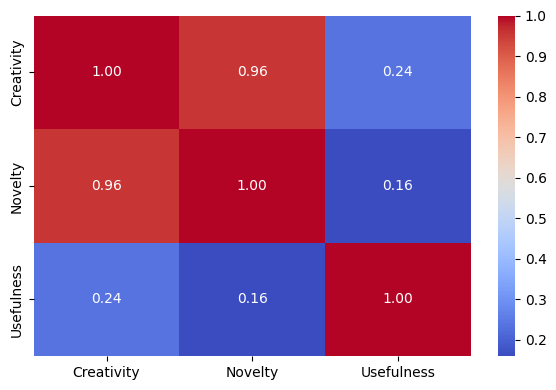

In [11]:
# Combine both dataframes
df_rating = pd.concat([df_ideas, df_chatgpt], ignore_index=True)
ratings = df_rating[['avg_creativity_rating', 'avg_novelty_rating', 'avg_usefulness_rating']]

# Compute correlation matrix
correlation_matrix = ratings.corr(method='pearson')
print("Correlation Matrix:")
print(correlation_matrix)

# plot heatmap
dimension = {
    'avg_creativity_rating': 'Creativity',
    'avg_novelty_rating': 'Novelty',
    'avg_usefulness_rating': 'Usefulness'}
correlation_matrix.rename(index=dimension, columns=dimension, inplace=True)
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
#plt.title("Correlation between Creativity, Novelty, and Usefulness")
plt.tight_layout()
plt.show()


In [12]:
# Drop N/A
ratings_clean = df_rating[['avg_creativity_rating', 'avg_novelty_rating', 'avg_usefulness_rating']].dropna()

# Compute correlations
r1, p1 = pearsonr(ratings_clean['avg_creativity_rating'], ratings_clean['avg_novelty_rating'])
r2, p2 = pearsonr(ratings_clean['avg_creativity_rating'], ratings_clean['avg_usefulness_rating'])
r3, p3 = pearsonr(ratings_clean['avg_novelty_rating'], ratings_clean['avg_usefulness_rating'])

print(f"Creativity vs Novelty:      r = {r1:.3f}, p = {p1:.4f}")
print(f"Creativity vs Usefulness:   r = {r2:.3f}, p = {p2:.4f}")
print(f"Novelty vs Usefulness:      r = {r3:.3f}, p = {p3:.4f}")


Creativity vs Novelty:      r = 0.956, p = 0.0000
Creativity vs Usefulness:   r = 0.237, p = 0.0069
Novelty vs Usefulness:      r = 0.159, p = 0.0714


In [13]:
# Compute mean values + standard deviation for GroupAssignment
mean_creativity = df_ideas.groupby('GroupAssignment')['avg_creativity_rating'].mean()
std_creativity = df_ideas.groupby('GroupAssignment')['avg_creativity_rating'].std()
mean_novelty = df_ideas.groupby('GroupAssignment')['avg_novelty_rating'].mean()
std_novelty = df_ideas.groupby('GroupAssignment')['avg_novelty_rating'].std()
mean_usefulness = df_ideas.groupby('GroupAssignment')['avg_usefulness_rating'].mean()
std_usefulness = df_ideas.groupby('GroupAssignment')['avg_usefulness_rating'].std()

print("Creativity by group:", mean_creativity, std_creativity)
print("Novelty by group:", mean_novelty, std_novelty)
print("Usefulness by group:", mean_usefulness, std_usefulness)

Creativity by group: GroupAssignment
Human/AI_Human       0.427249
Human/AI_Human/AI    0.401361
Human_Human          0.489011
Human_Human/AI       0.521978
Name: avg_creativity_rating, dtype: float64 GroupAssignment
Human/AI_Human       0.135628
Human/AI_Human/AI    0.176742
Human_Human          0.219408
Human_Human/AI       0.221561
Name: avg_creativity_rating, dtype: float64
Novelty by group: GroupAssignment
Human/AI_Human       0.406085
Human/AI_Human/AI    0.353741
Human_Human          0.505495
Human_Human/AI       0.520604
Name: avg_novelty_rating, dtype: float64 GroupAssignment
Human/AI_Human       0.149944
Human/AI_Human/AI    0.176381
Human_Human          0.237266
Human_Human/AI       0.240784
Name: avg_novelty_rating, dtype: float64
Usefulness by group: GroupAssignment
Human/AI_Human       0.546296
Human/AI_Human/AI    0.581633
Human_Human          0.480000
Human_Human/AI       0.576007
Name: avg_usefulness_rating, dtype: float64 GroupAssignment
Human/AI_Human       0.131340


                              OLS Regression Results                             
Dep. Variable:     avg_creativity_rating   R-squared:                       0.059
Model:                               OLS   Adj. R-squared:                  0.030
Method:                    Least Squares   F-statistic:                     2.013
Date:                   Mon, 14 Apr 2025   Prob (F-statistic):              0.117
Time:                           08:59:02   Log-Likelihood:                 25.247
No. Observations:                    100   AIC:                            -42.49
Df Residuals:                         96   BIC:                            -32.07
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

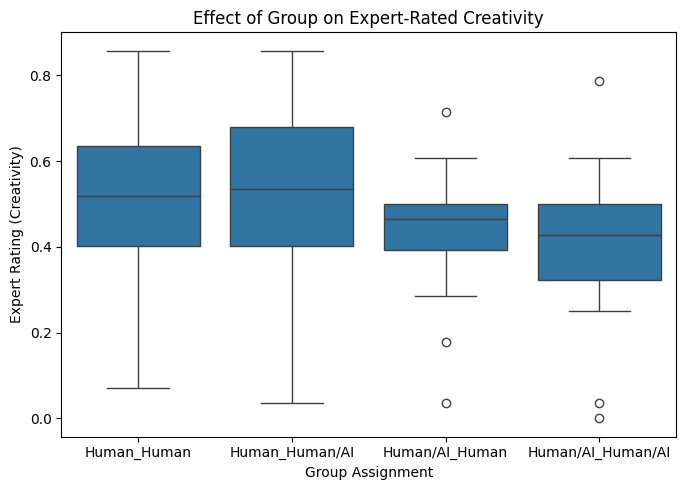

In [14]:
# Creativity + GroupAssignment
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# drop N/A
df_ideas = df_ideas.dropna(subset=["GroupAssignment"])

# design OLS regression
formula = ('avg_creativity_rating ~ C(GroupAssignment, Treatment(reference="Human_Human"))')
model = smf.ols(formula, data=df_ideas).fit()
print(model.summary())

# box plot showing differences
plt.figure(figsize=(7, 5))
sns.boxplot(x="GroupAssignment", y="avg_creativity_rating", data=df_ideas)
plt.xlabel("Group Assignment")
plt.ylabel("Expert Rating (Creativity)")
plt.title("Effect of Group on Expert-Rated Creativity")
plt.tight_layout()
plt.show()


                              OLS Regression Results                             
Dep. Variable:     avg_creativity_rating   R-squared:                       0.116
Model:                               OLS   Adj. R-squared:                  0.017
Method:                    Least Squares   F-statistic:                     1.166
Date:                   Mon, 14 Apr 2025   Prob (F-statistic):              0.324
Time:                           08:59:02   Log-Likelihood:                 28.352
No. Observations:                    100   AIC:                            -34.70
Df Residuals:                         89   BIC:                            -6.048
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

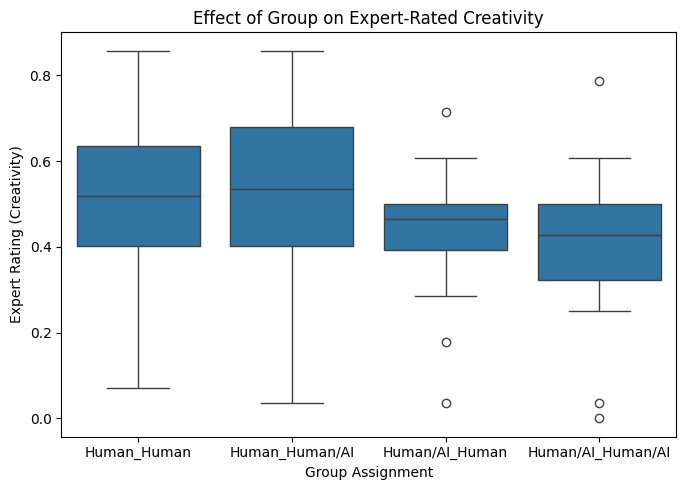

In [15]:
# Creativity + GroupAssignment + Controls

# define control variables
predictors = [
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# drop N/A
df_ideas = df_ideas.dropna(subset = predictors + ["GroupAssignment"])

# design OLS regression
formula = ('avg_creativity_rating ~ C(GroupAssignment, Treatment(reference="Human_Human"))''+ DAT_score_standardized + BusinessFamiliarity_High + EngExp_High + InnoMgmtExp_High + SustainabilityExp_High + GenAIExp_High + Gender_Male')
model = smf.ols(formula, data=df_ideas).fit()
print(model.summary())

# box plot showing differences
plt.figure(figsize=(7, 5))
sns.boxplot(x="GroupAssignment", y="avg_creativity_rating", data=df_ideas)
plt.xlabel("Group Assignment")
plt.ylabel("Expert Rating (Creativity)")
plt.title("Effect of Group on Expert-Rated Creativity")
plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:     avg_novelty_rating   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     3.593
Date:                Mon, 14 Apr 2025   Prob (F-statistic):             0.0164
Time:                        08:59:02   Log-Likelihood:                 18.262
No. Observations:                 100   AIC:                            -28.52
Df Residuals:                      96   BIC:                            -18.10
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

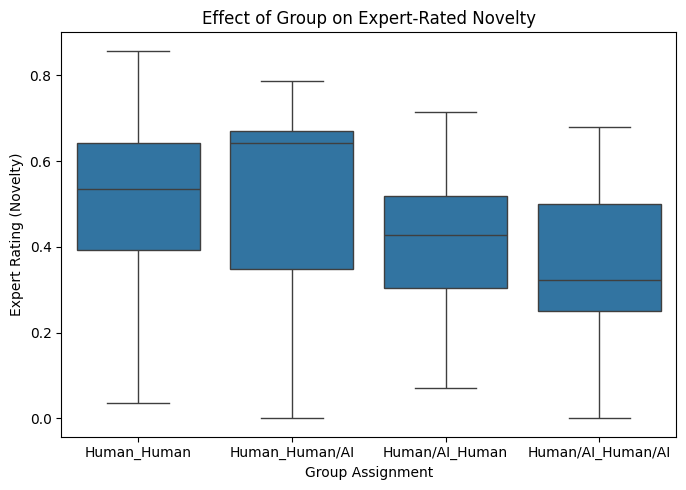

In [16]:
# Novelty + GroupAssignment
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# drop N/A
df_ideas = df_ideas.dropna(subset=["GroupAssignment"])

# design OLS regression
formula = ('avg_novelty_rating ~ C(GroupAssignment, Treatment(reference="Human_Human"))')
model = smf.ols(formula, data=df_ideas).fit()
print(model.summary())

# box plot showing differences
plt.figure(figsize=(7, 5))
sns.boxplot(x="GroupAssignment", y="avg_novelty_rating", data=df_ideas)
plt.xlabel("Group Assignment")
plt.ylabel("Expert Rating (Novelty)")
plt.title("Effect of Group on Expert-Rated Novelty")
plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:     avg_novelty_rating   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     1.647
Date:                Mon, 14 Apr 2025   Prob (F-statistic):              0.106
Time:                        08:59:02   Log-Likelihood:                 21.432
No. Observations:                 100   AIC:                            -20.86
Df Residuals:                      89   BIC:                             7.793
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

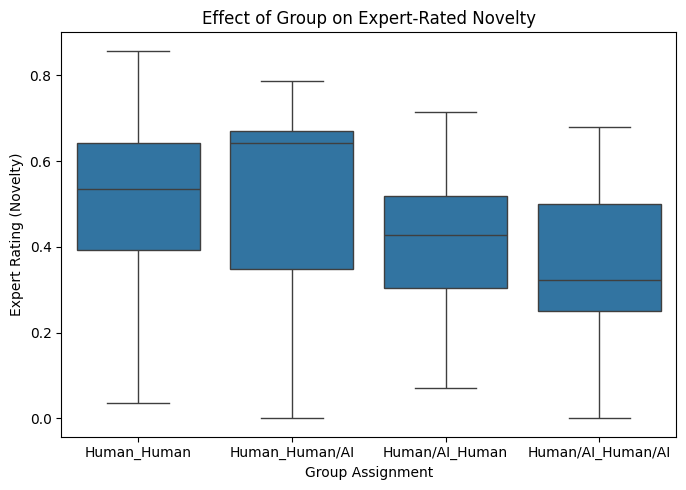

In [17]:
# Novelty + GroupAssignment + Controls
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# define control variables
predictors = [
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# drop N/A
df_ideas = df_ideas.dropna(subset = predictors + ["GroupAssignment"])

# design OLS regression
formula = ('avg_novelty_rating ~ C(GroupAssignment, Treatment(reference="Human_Human"))''+ DAT_score_standardized + BusinessFamiliarity_High + EngExp_High + InnoMgmtExp_High + SustainabilityExp_High + GenAIExp_High + Gender_Male')
model = smf.ols(formula, data=df_ideas).fit()
print(model.summary())

# box plot showing differences
plt.figure(figsize=(7, 5))
sns.boxplot(x="GroupAssignment", y="avg_novelty_rating", data=df_ideas)
plt.xlabel("Group Assignment")
plt.ylabel("Expert Rating (Novelty)")
plt.title("Effect of Group on Expert-Rated Novelty")
plt.tight_layout()
plt.show()


                              OLS Regression Results                             
Dep. Variable:     avg_usefulness_rating   R-squared:                       0.088
Model:                               OLS   Adj. R-squared:                  0.059
Method:                    Least Squares   F-statistic:                     3.054
Date:                   Mon, 14 Apr 2025   Prob (F-statistic):             0.0322
Time:                           08:59:03   Log-Likelihood:                 62.278
No. Observations:                     99   AIC:                            -116.6
Df Residuals:                         95   BIC:                            -106.2
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

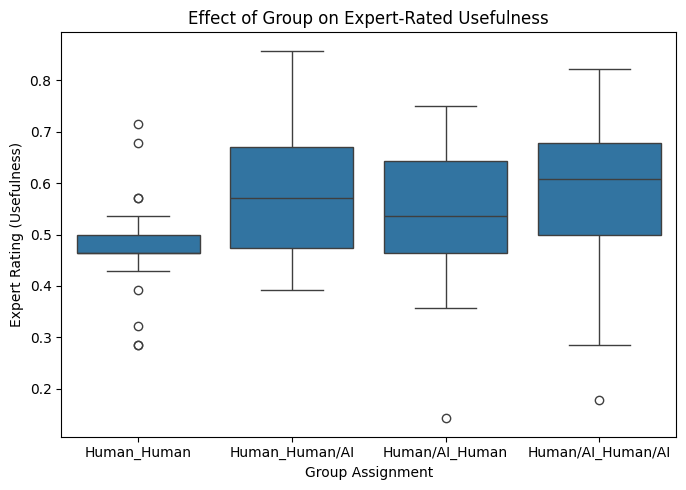

In [18]:
# Usefulness + GroupAssignment
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# drop N/A
df_ideas = df_ideas.dropna(subset=["GroupAssignment"])

# design OLS regression 
formula = ('avg_usefulness_rating ~ C(GroupAssignment, Treatment(reference="Human_Human"))')
model = smf.ols(formula, data=df_ideas).fit()
print(model.summary())

# box plot showing differences
plt.figure(figsize=(7, 5))
sns.boxplot(x="GroupAssignment", y="avg_usefulness_rating", data=df_ideas)
plt.xlabel("Group Assignment")
plt.ylabel("Expert Rating (Usefulness)")
plt.title("Effect of Group on Expert-Rated Usefulness")
plt.tight_layout()
plt.show()


                              OLS Regression Results                             
Dep. Variable:     avg_usefulness_rating   R-squared:                       0.116
Model:                               OLS   Adj. R-squared:                  0.015
Method:                    Least Squares   F-statistic:                     1.150
Date:                   Mon, 14 Apr 2025   Prob (F-statistic):              0.335
Time:                           08:59:03   Log-Likelihood:                 63.803
No. Observations:                     99   AIC:                            -105.6
Df Residuals:                         88   BIC:                            -77.06
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

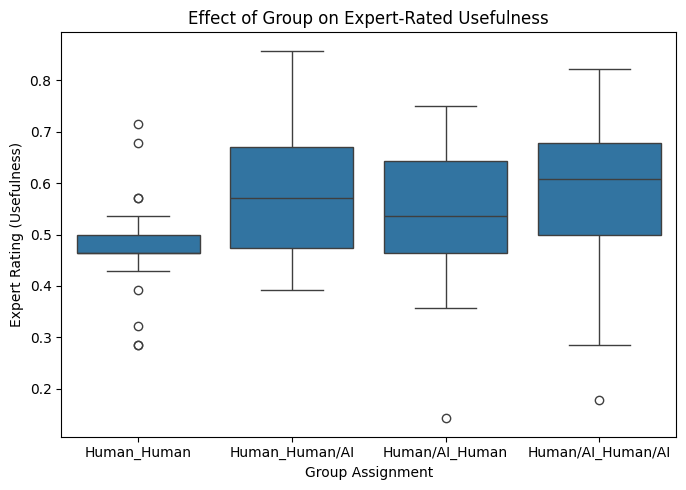

In [19]:
# Usefulness + GroupAssignment + Controls
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# define control variables
predictors = [
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# drop N/A
df_ideas = df_ideas.dropna(subset = predictors + ["GroupAssignment"])

# design OLS regression
formula = ('avg_usefulness_rating ~ C(GroupAssignment, Treatment(reference="Human_Human"))''+ DAT_score_standardized + BusinessFamiliarity_High + EngExp_High + InnoMgmtExp_High + SustainabilityExp_High + GenAIExp_High + Gender_Male')
model = smf.ols(formula, data=df_ideas).fit()
print(model.summary())

# box plot showing differences
plt.figure(figsize=(7, 5))
sns.boxplot(x="GroupAssignment", y="avg_usefulness_rating", data=df_ideas)
plt.xlabel("Group Assignment")
plt.ylabel("Expert Rating (Usefulness)")
plt.title("Effect of Group on Expert-Rated Usefulness")
plt.tight_layout()
plt.show()


In [20]:
# Compute mean + SD for Task1_ChatGPT
mean_creativity = df_ideas.groupby('Task1_ChatGPT_Access')['avg_creativity_rating'].mean()
std_creativity = df_ideas.groupby('Task1_ChatGPT_Access')['avg_creativity_rating'].std()
mean_novelty = df_ideas.groupby('Task1_ChatGPT_Access')['avg_novelty_rating'].mean()
std_novelty = df_ideas.groupby('Task1_ChatGPT_Access')['avg_novelty_rating'].std()
mean_usefulness = df_ideas.groupby('Task1_ChatGPT_Access')['avg_usefulness_rating'].mean()
std_usefulness = df_ideas.groupby('Task1_ChatGPT_Access')['avg_usefulness_rating'].std()

print("Creativity by task 1 acess:", mean_creativity, std_creativity)
print("Novelty by task 1 access:", mean_novelty, std_novelty)
print("Usefulness by task 1 access:", mean_usefulness, std_usefulness)

Creativity by task 1 acess: Task1_ChatGPT_Access
0.0    0.505495
1.0    0.415923
Name: avg_creativity_rating, dtype: float64 Task1_ChatGPT_Access
0.0    0.218948
1.0    0.153744
Name: avg_creativity_rating, dtype: float64
Novelty by task 1 access: Task1_ChatGPT_Access
0.0    0.513049
1.0    0.383185
Name: avg_novelty_rating, dtype: float64 Task1_ChatGPT_Access
0.0    0.236799
1.0    0.162371
Name: avg_novelty_rating, dtype: float64
Usefulness by task 1 access: Task1_ChatGPT_Access
0.0    0.528945
1.0    0.561756
Name: avg_usefulness_rating, dtype: float64 Task1_ChatGPT_Access
0.0    0.129522
1.0    0.141471
Name: avg_usefulness_rating, dtype: float64


In [21]:
# Compute mean + SD for Task2_ChatGPT
mean_creativity = df_ideas.groupby('Task2_ChatGPT_Access')['avg_creativity_rating'].mean()
std_creativity = df_ideas.groupby('Task2_ChatGPT_Access')['avg_creativity_rating'].std()
mean_novelty = df_ideas.groupby('Task2_ChatGPT_Access')['avg_novelty_rating'].mean()
std_novelty = df_ideas.groupby('Task2_ChatGPT_Access')['avg_novelty_rating'].std()
mean_usefulness = df_ideas.groupby('Task2_ChatGPT_Access')['avg_usefulness_rating'].mean()
std_usefulness = df_ideas.groupby('Task2_ChatGPT_Access')['avg_usefulness_rating'].std()

print("Creativity by task 2 acess:", mean_creativity, std_creativity)
print("Novelty by task 2 access:", mean_novelty, std_novelty)
print("Usefulness by task 2 access:", mean_usefulness, std_usefulness)

Creativity by task 2 acess: Task2_ChatGPT_Access
0.0    0.457547
1.0    0.468085
Name: avg_creativity_rating, dtype: float64 Task2_ChatGPT_Access
0.0    0.182519
1.0    0.209607
Name: avg_creativity_rating, dtype: float64
Novelty by task 2 access: Task2_ChatGPT_Access
0.0    0.454852
1.0    0.446049
Name: avg_novelty_rating, dtype: float64 Task2_ChatGPT_Access
0.0    0.202049
1.0    0.228182
Name: avg_novelty_rating, dtype: float64
Usefulness by task 2 access: Task2_ChatGPT_Access
0.0    0.514423
1.0    0.578521
Name: avg_usefulness_rating, dtype: float64 Task2_ChatGPT_Access
0.0    0.120286
1.0    0.144969
Name: avg_usefulness_rating, dtype: float64


                              OLS Regression Results                             
Dep. Variable:     avg_creativity_rating   R-squared:                       0.053
Model:                               OLS   Adj. R-squared:                  0.034
Method:                    Least Squares   F-statistic:                     2.740
Date:                   Mon, 14 Apr 2025   Prob (F-statistic):             0.0696
Time:                           09:00:57   Log-Likelihood:                 24.944
No. Observations:                    100   AIC:                            -43.89
Df Residuals:                         97   BIC:                            -36.07
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
co

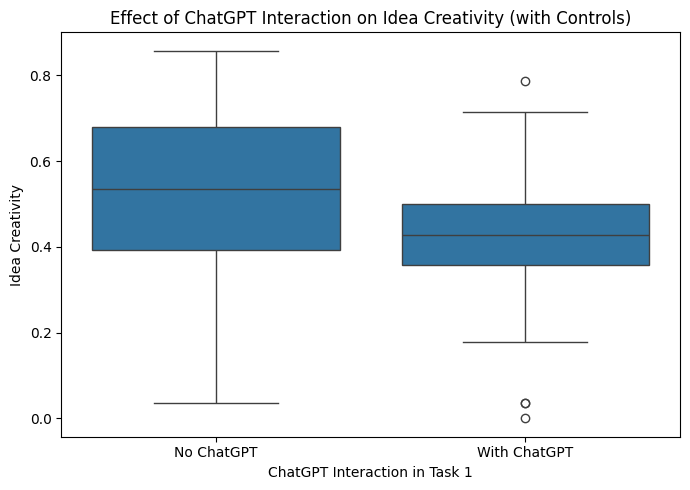

In [23]:
# Creativity + Task-Access

# Define predictor
predictors = [
    'Task1_ChatGPT_Access',
    'Task2_ChatGPT_Access'
]

# Drop N/A 
df = df_ideas.dropna(subset=predictors + ["avg_creativity_rating"])

# Define the OLS model
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["avg_creativity_rating"]
model = sm.OLS(y, X).fit()
print(model.summary())

# Box plot showing differences in group
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task1_ChatGPT_Access", y="avg_creativity_rating", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Interaction in Task 1")
plt.ylabel("Idea Creativity")
plt.title("Effect of ChatGPT Interaction on Idea Creativity (with Controls)")
plt.tight_layout()
plt.show()


                              OLS Regression Results                             
Dep. Variable:     avg_creativity_rating   R-squared:                       0.049
Model:                               OLS   Adj. R-squared:                  0.030
Method:                    Least Squares   F-statistic:                     2.505
Date:                   Mon, 14 Apr 2025   Prob (F-statistic):             0.0869
Time:                           09:01:00   Log-Likelihood:                 24.715
No. Observations:                    100   AIC:                            -43.43
Df Residuals:                         97   BIC:                            -35.61
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

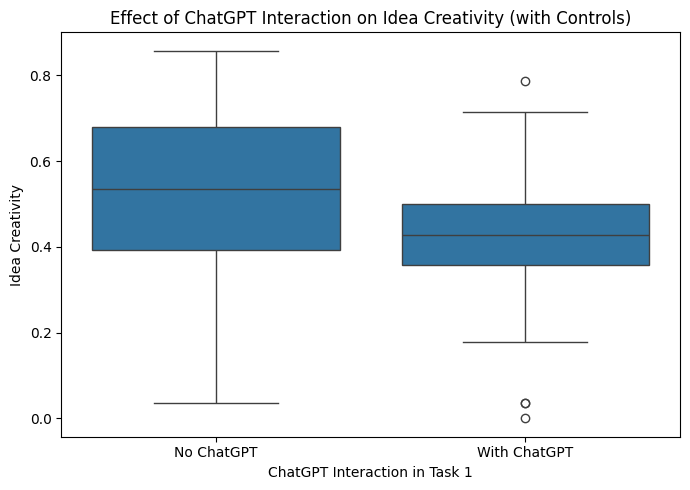

In [24]:
# Creativity + Task-Interaction

# Define predictor
predictors = [
    'Task1_ChatGPT_Interaction',
    'Task2_ChatGPT_Interaction'
]

# Drop N/A 
df = df_ideas.dropna(subset=predictors + ["avg_creativity_rating"])

# Define the OLS model
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["avg_creativity_rating"]
model = sm.OLS(y, X).fit()
print(model.summary())

# Box plot showing differences in group
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task1_ChatGPT_Interaction", y="avg_creativity_rating", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Interaction in Task 1")
plt.ylabel("Idea Creativity")
plt.title("Effect of ChatGPT Interaction on Idea Creativity (with Controls)")
plt.tight_layout()
plt.show()


                              OLS Regression Results                             
Dep. Variable:     avg_creativity_rating   R-squared:                       0.113
Model:                               OLS   Adj. R-squared:                  0.025
Method:                    Least Squares   F-statistic:                     1.279
Date:                   Mon, 14 Apr 2025   Prob (F-statistic):              0.259
Time:                           09:01:03   Log-Likelihood:                 28.213
No. Observations:                    100   AIC:                            -36.43
Df Residuals:                         90   BIC:                            -10.37
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

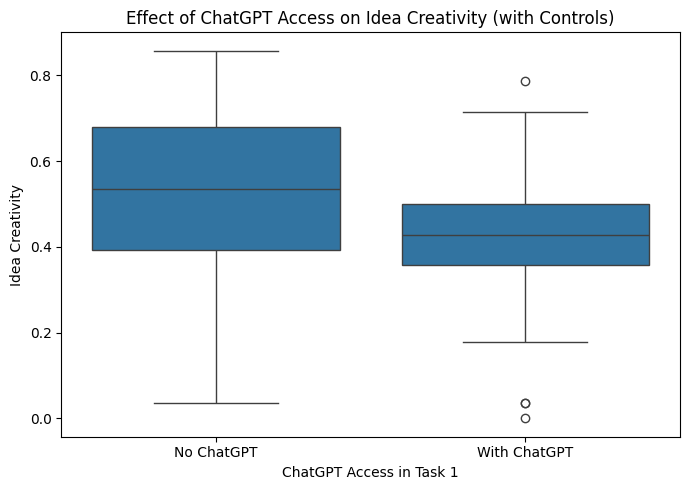

In [25]:
# Creativity + Task-Access + Control

# Define predictor
predictors = [
    'Task1_ChatGPT_Access',
    'Task2_ChatGPT_Access',
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# Drop N/A 
df = df_ideas.dropna(subset=predictors + ["avg_creativity_rating"])

# Define the OLS model
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["avg_creativity_rating"]
model = sm.OLS(y, X).fit()
print(model.summary())

# Box plot showing differences in group
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task1_ChatGPT_Access", y="avg_creativity_rating", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Access in Task 1")
plt.ylabel("Idea Creativity")
plt.title("Effect of ChatGPT Access on Idea Creativity (with Controls)")
plt.tight_layout()
plt.show()


                              OLS Regression Results                             
Dep. Variable:     avg_creativity_rating   R-squared:                       0.111
Model:                               OLS   Adj. R-squared:                  0.022
Method:                    Least Squares   F-statistic:                     1.245
Date:                   Mon, 14 Apr 2025   Prob (F-statistic):              0.278
Time:                           09:01:05   Log-Likelihood:                 28.064
No. Observations:                    100   AIC:                            -36.13
Df Residuals:                         90   BIC:                            -10.08
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

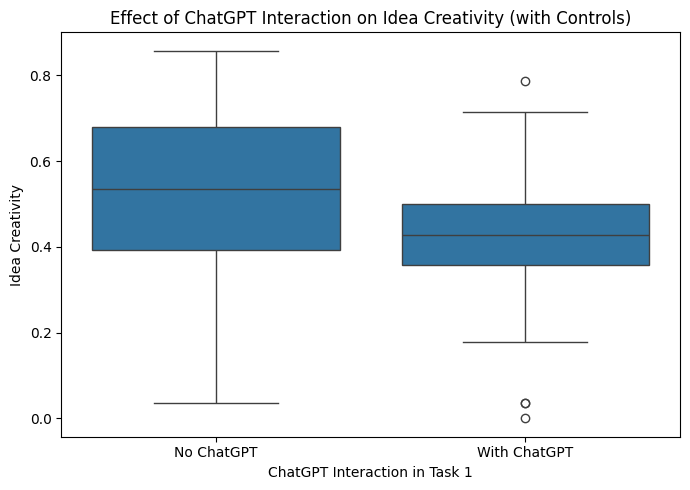

In [26]:
# Creativity + Task-Interaction + Control

# Define predictor
predictors = [
    'Task1_ChatGPT_Interaction',
    'Task2_ChatGPT_Interaction',
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# Drop N/A 
df = df_ideas.dropna(subset=predictors + ["avg_creativity_rating"])

# Define the OLS model
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["avg_creativity_rating"]
model = sm.OLS(y, X).fit()
print(model.summary())

# Box plot showing differences in group
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task1_ChatGPT_Interaction", y="avg_creativity_rating", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Interaction in Task 1")
plt.ylabel("Idea Creativity")
plt.title("Effect of ChatGPT Interaction on Idea Creativity (with Controls)")
plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:     avg_novelty_rating   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     5.075
Date:                Mon, 14 Apr 2025   Prob (F-statistic):            0.00802
Time:                        09:01:09   Log-Likelihood:                 17.916
No. Observations:                 100   AIC:                            -29.83
Df Residuals:                      97   BIC:                            -22.02
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5216 

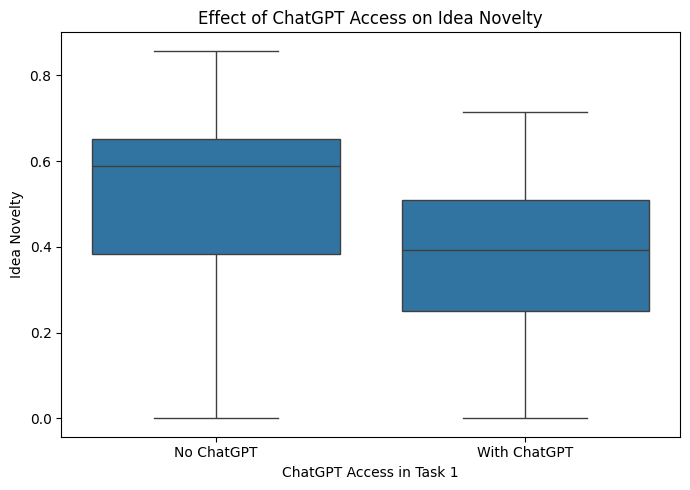

In [27]:
# Novelty + Task-Access 

# Define predictor
predictors = [
    'Task1_ChatGPT_Access',
    'Task2_ChatGPT_Access'
]

# Drop N/A 
df = df_ideas.dropna(subset=predictors + ["avg_novelty_rating"])

# Define the OLS model
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["avg_novelty_rating"]
model = sm.OLS(y, X).fit()
print(model.summary())

# Box plot showing differences in group
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task1_ChatGPT_Access", y="avg_novelty_rating", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Access in Task 1")
plt.ylabel("Idea Novelty")
plt.title("Effect of ChatGPT Access on Idea Novelty")
plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:     avg_novelty_rating   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     4.588
Date:                Mon, 14 Apr 2025   Prob (F-statistic):             0.0125
Time:                        09:01:11   Log-Likelihood:                 17.460
No. Observations:                 100   AIC:                            -28.92
Df Residuals:                      97   BIC:                            -21.11
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

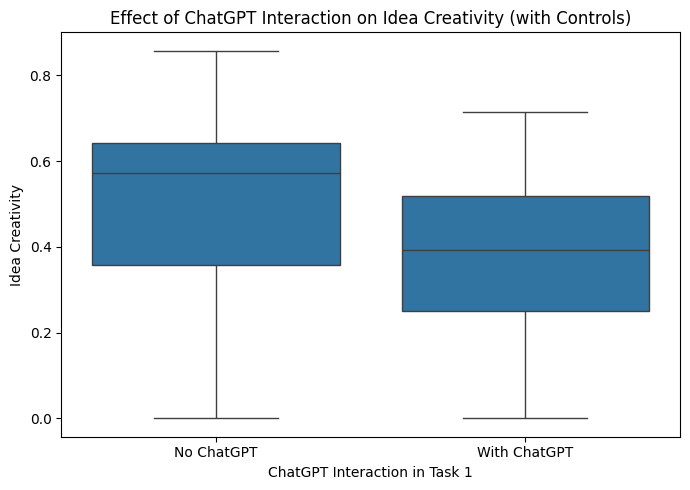

In [28]:
# Novelty + Task-Interaction 

# Define predictor
predictors = [
    'Task1_ChatGPT_Interaction',
    'Task2_ChatGPT_Interaction'
]

# Drop N/A 
df = df_ideas.dropna(subset=predictors + ["avg_novelty_rating"])

# Define the OLS model
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["avg_novelty_rating"]
model = sm.OLS(y, X).fit()
print(model.summary())

# Box plot showing differences in group
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task1_ChatGPT_Interaction", y="avg_novelty_rating", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Interaction in Task 1")
plt.ylabel("Idea Creativity")
plt.title("Effect of ChatGPT Interaction on Idea Creativity (with Controls)")
plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:     avg_novelty_rating   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     1.827
Date:                Mon, 14 Apr 2025   Prob (F-statistic):             0.0740
Time:                        09:01:14   Log-Likelihood:                 21.330
No. Observations:                 100   AIC:                            -22.66
Df Residuals:                      90   BIC:                             3.391
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

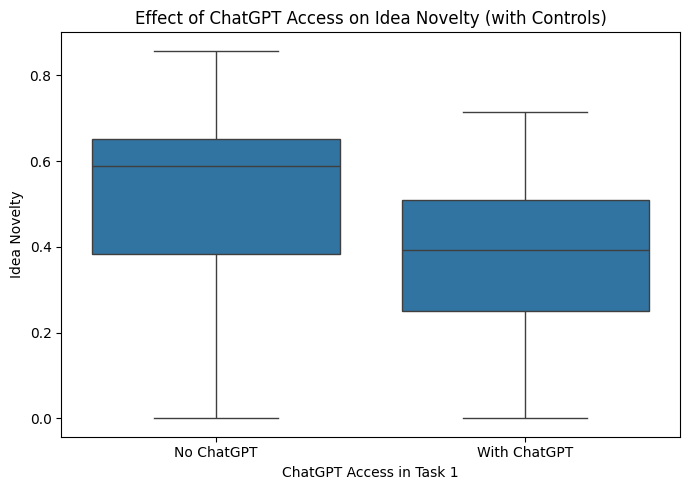

In [29]:
# Novelty + Task-Access + Control

# Define predictor
predictors = [
    'Task1_ChatGPT_Access',
    'Task2_ChatGPT_Access',
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# Drop N/A 
df = df_ideas.dropna(subset=predictors + ["avg_novelty_rating"])

# Define the OLS model
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["avg_novelty_rating"]
model = sm.OLS(y, X).fit()
print(model.summary())

# Box plot showing differences in group
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task1_ChatGPT_Access", y="avg_novelty_rating", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Access in Task 1")
plt.ylabel("Idea Novelty")
plt.title("Effect of ChatGPT Access on Idea Novelty (with Controls)")
plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:     avg_novelty_rating   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     1.776
Date:                Mon, 14 Apr 2025   Prob (F-statistic):             0.0838
Time:                        09:01:26   Log-Likelihood:                 21.113
No. Observations:                 100   AIC:                            -22.23
Df Residuals:                      90   BIC:                             3.826
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

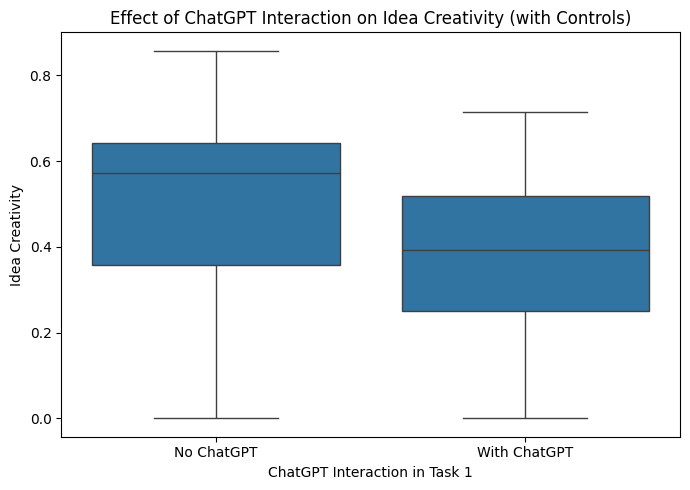

In [30]:
# Novelty + Task-Interaction + Control

# Define predictor
predictors = [
    'Task1_ChatGPT_Interaction',
    'Task2_ChatGPT_Interaction',
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# Drop N/A 
df = df_ideas.dropna(subset=predictors + ["avg_novelty_rating"])

# Define the OLS model
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["avg_novelty_rating"]
model = sm.OLS(y, X).fit()
print(model.summary())

# Box plot showing differences in group
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task1_ChatGPT_Interaction", y="avg_novelty_rating", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Interaction in Task 1")
plt.ylabel("Idea Creativity")
plt.title("Effect of ChatGPT Interaction on Idea Creativity (with Controls)")
plt.tight_layout()
plt.show()


                              OLS Regression Results                             
Dep. Variable:     avg_usefulness_rating   R-squared:                       0.075
Model:                               OLS   Adj. R-squared:                  0.056
Method:                    Least Squares   F-statistic:                     3.918
Date:                   Mon, 14 Apr 2025   Prob (F-statistic):             0.0231
Time:                           09:01:28   Log-Likelihood:                 61.605
No. Observations:                     99   AIC:                            -117.2
Df Residuals:                         96   BIC:                            -109.4
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
co

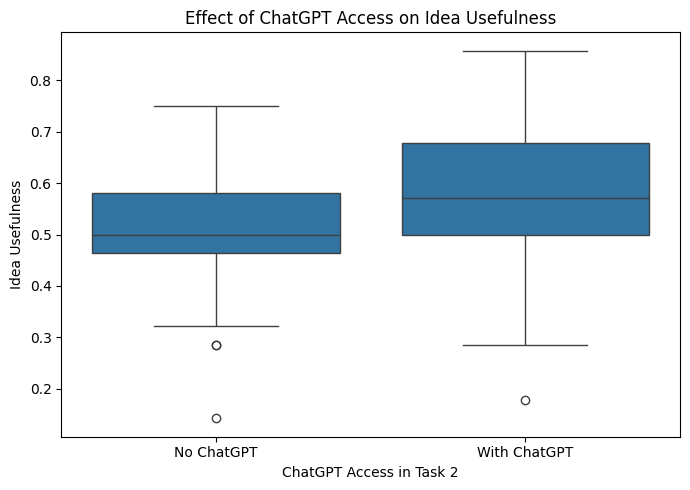

In [31]:
# Usefulness + Task-Access 

# Define predictor
predictors = [
    'Task1_ChatGPT_Access',
    'Task2_ChatGPT_Access'
]

# Drop N/A 
df = df_ideas.dropna(subset=predictors + ["avg_usefulness_rating"])

# Define the OLS model
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["avg_usefulness_rating"]
model = sm.OLS(y, X).fit()
print(model.summary())

# Box plot showing differences in group
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task2_ChatGPT_Access", y="avg_usefulness_rating", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Access in Task 2")
plt.ylabel("Idea Usefulness")
plt.title("Effect of ChatGPT Access on Idea Usefulness")
plt.tight_layout()
plt.show()


                              OLS Regression Results                             
Dep. Variable:     avg_usefulness_rating   R-squared:                       0.164
Model:                               OLS   Adj. R-squared:                  0.147
Method:                    Least Squares   F-statistic:                     9.424
Date:                   Mon, 14 Apr 2025   Prob (F-statistic):           0.000183
Time:                           09:01:31   Log-Likelihood:                 66.595
No. Observations:                     99   AIC:                            -127.2
Df Residuals:                         96   BIC:                            -119.4
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

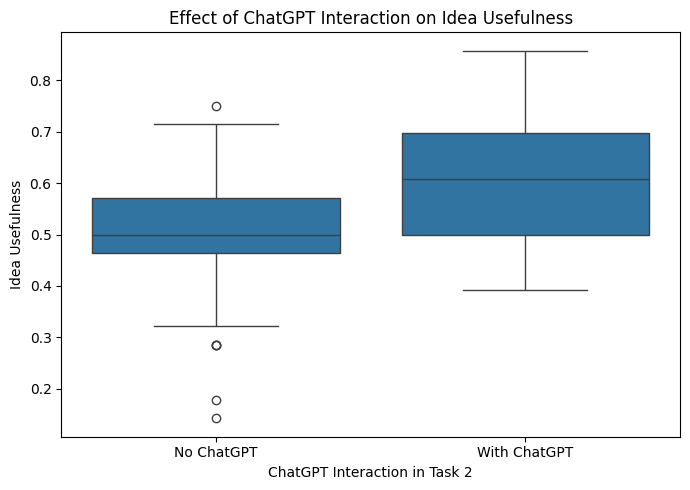

In [32]:
# Usefulness + Task-Access 

# Define predictor
predictors = [
    'Task1_ChatGPT_Interaction',
    'Task2_ChatGPT_Interaction'
]

# Drop N/A 
df = df_ideas.dropna(subset=predictors + ["avg_usefulness_rating"])

# Define the OLS model
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["avg_usefulness_rating"]
model = sm.OLS(y, X).fit()
print(model.summary())

# Box plot showing differences in group
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task2_ChatGPT_Interaction", y="avg_usefulness_rating", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Interaction in Task 2")
plt.ylabel("Idea Usefulness")
plt.title("Effect of ChatGPT Interaction on Idea Usefulness")
plt.tight_layout()
plt.show()


                              OLS Regression Results                             
Dep. Variable:     avg_usefulness_rating   R-squared:                       0.102
Model:                               OLS   Adj. R-squared:                  0.012
Method:                    Least Squares   F-statistic:                     1.127
Date:                   Mon, 14 Apr 2025   Prob (F-statistic):              0.352
Time:                           09:01:34   Log-Likelihood:                 63.064
No. Observations:                     99   AIC:                            -106.1
Df Residuals:                         89   BIC:                            -80.18
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

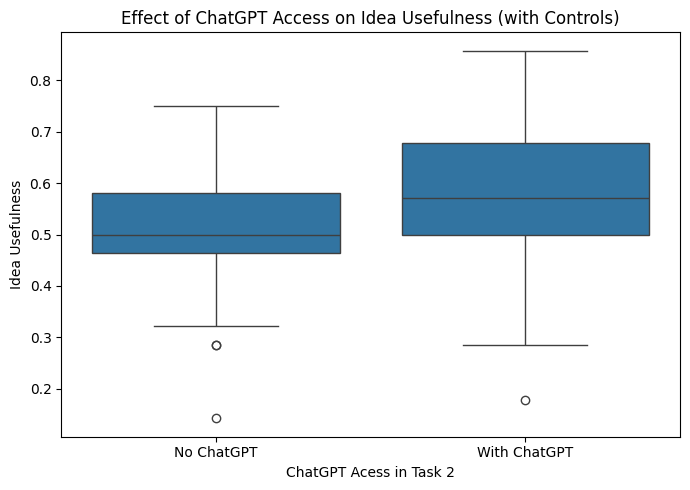

In [33]:
# Novelty + Task-Access + Control

# Define predictor
predictors = [
    'Task1_ChatGPT_Access',
    'Task2_ChatGPT_Access',
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# Drop N/A 
df = df_ideas.dropna(subset=predictors + ["avg_usefulness_rating"])

# Define the OLS model
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["avg_usefulness_rating"]
model = sm.OLS(y, X).fit()
print(model.summary())

# Box plot showing differences in group
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task2_ChatGPT_Access", y="avg_usefulness_rating", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Acess in Task 2")
plt.ylabel("Idea Usefulness")
plt.title("Effect of ChatGPT Access on Idea Usefulness (with Controls)")
plt.tight_layout()
plt.show()


                              OLS Regression Results                             
Dep. Variable:     avg_usefulness_rating   R-squared:                       0.190
Model:                               OLS   Adj. R-squared:                  0.108
Method:                    Least Squares   F-statistic:                     2.315
Date:                   Mon, 14 Apr 2025   Prob (F-statistic):             0.0217
Time:                           09:01:36   Log-Likelihood:                 68.134
No. Observations:                     99   AIC:                            -116.3
Df Residuals:                         89   BIC:                            -90.32
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

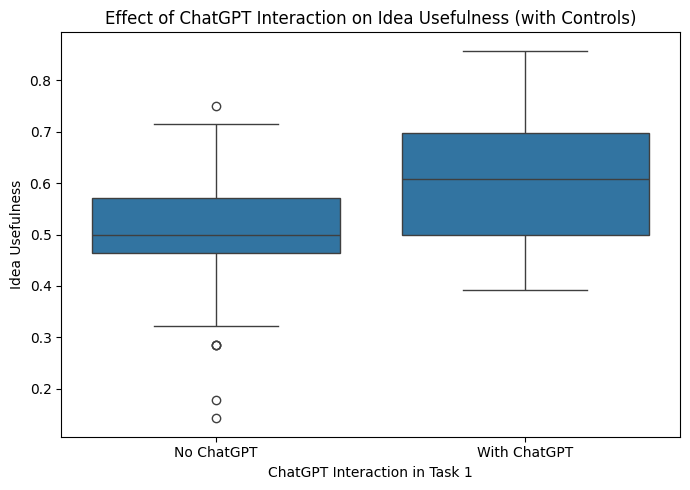

In [34]:
# Novelty + Task-Access + Control

# Define predictor
predictors = [
    'Task1_ChatGPT_Interaction',
    'Task2_ChatGPT_Interaction',
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# Drop N/A 
df = df_ideas.dropna(subset=predictors + ["avg_usefulness_rating"])

# Define the OLS model
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["avg_usefulness_rating"]
model = sm.OLS(y, X).fit()
print(model.summary())

# Box plot showing differences in group
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task2_ChatGPT_Interaction", y="avg_usefulness_rating", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Interaction in Task 1")
plt.ylabel("Idea Usefulness")
plt.title("Effect of ChatGPT Interaction on Idea Usefulness (with Controls)")
plt.tight_layout()
plt.show()


In [35]:
# Compute Mean and SD for chatGPT answers
mean_creativity = df_chatgpt['avg_creativity_rating'].mean()
mean_novelty = df_chatgpt['avg_novelty_rating'].mean()
mean_usefulness = df_chatgpt['avg_usefulness_rating'].mean()

print("Mean creativity of AI:", mean_creativity)
print("Mean novelty of AI:", mean_novelty)
print("Mean usefulenss of AI:", mean_usefulness)

Mean creativity of AI: 0.45976190476190476
Mean novelty of AI: 0.4319047619047619
Mean usefulenss of AI: 0.6447619047619046


In [36]:
df_chatgpt['GroupAssignment'] = "AI_AI"
df_all_ideas = pd.concat([df_ideas, df_chatgpt], ignore_index=True)
display(df_all_ideas)

,Idea_ID,avg_creativity_rating,avg_novelty_rating,avg_usefulness_rating,Response ID,idea_elaboration,GroupAssignment,Task1_ChatGPT_Access,Task1_ChatGPT_Interaction,Task2_ChatGPT_Access,...,BusinessFamiliarity_High,EngExp_High,ProfField_Business,InnoMgmtExp_High,SustainabilityExp_High,GenAIExp_High,GenAIFrequency_High,Age_35+,Gender_Male,DAT_score_standardized
0,R_1VllX72TovsGQQP,0.500000,0.571429,0.500000,R_1VllX72TovsGQQP,Delivery packaging waste is one of the main so...,Human_Human,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,-0.421186
1,R_1qDuAKmI1NSxncV,0.357143,0.357143,0.464286,R_1qDuAKmI1NSxncV,Blue and green roofs. Especially in city’s it ...,Human_Human,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.586911
2,R_20ZHsH9Y3Zhv6Z0,0.392857,0.285714,0.500000,R_20ZHsH9Y3Zhv6Z0,Low-Flow Fixtures: Upgrade to low-flow faucets...,Human_Human/AI,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.514218
3,R_20cuzY5RvsACUOx,0.392857,0.321429,0.607143,R_20cuzY5RvsACUOx,A digital sustainability coach is an AI-based ...,Human/AI_Human,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.407626
4,R_20pCSLhwpy6fYB6,0.678571,0.642857,0.392857,R_20pCSLhwpy6fYB6,Creating a countrywide deposit system for wine...,Human_Human/AI,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.221899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,AI5,0.500000,0.464286,0.642857,NaN,NaN,AI_AI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,AI6,0.500000,0.535714,0.642857,NaN,NaN,AI_AI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,AI7,0.500000,0.500000,0.607143,NaN,NaN,AI_AI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,AI8,0.500000,0.535714,0.607143,NaN,NaN,AI_AI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Top 10% Creativity Threshold: 0.679
     GroupAssignment  TopCreativeIdeaCount
0     Human_Human/AI                    10
1        Human_Human                     4
2     Human/AI_Human                     1
3  Human/AI_Human/AI                     1
4              AI_AI                     1


/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_38609/261284963.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="GroupAssignment", y="TopCreativeIdeaCount", data=top_idea_counts, palette="viridis")


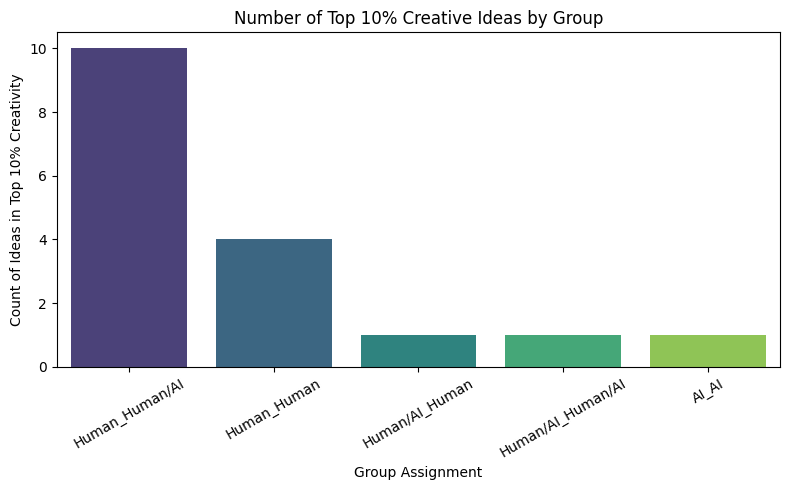

In [37]:
# Drop N/A
df_filtered = df_all_ideas.dropna(subset=["avg_creativity_rating", "GroupAssignment"])

# calculate threshold for 0.9 quantile
threshold = df_filtered["avg_creativity_rating"].quantile(0.90)

# filter based on threshold
df_top_creative = df_filtered[df_filtered["avg_creativity_rating"] >= threshold]

# count number of ideas
top_idea_counts = df_top_creative["GroupAssignment"].value_counts().reset_index()
top_idea_counts.columns = ["GroupAssignment", "TopCreativeIdeaCount"]

print("Top 10% Creativity Threshold:", round(threshold, 3))
print(top_idea_counts)

# plot number of ideas per group
plt.figure(figsize=(8, 5))
sns.barplot(x="GroupAssignment", y="TopCreativeIdeaCount", data=top_idea_counts, palette="viridis")
plt.title("Number of Top 10% Creative Ideas by Group")
plt.xlabel("Group Assignment")
plt.ylabel("Count of Ideas in Top 10% Creativity")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Top 10% Creativity Threshold: 0.679
                   count      mean       std       min       25%       50%  \
GroupAssignment                                                              
AI_AI                1.0  0.750000       NaN  0.750000  0.750000  0.750000   
Human/AI_Human       1.0  0.714286       NaN  0.714286  0.714286  0.714286   
Human/AI_Human/AI    1.0  0.785714       NaN  0.785714  0.785714  0.785714   
Human_Human          4.0  0.803571  0.046107  0.750000  0.776786  0.803571   
Human_Human/AI      10.0  0.721429  0.057833  0.678571  0.678571  0.696429   

                        75%       max  
GroupAssignment                        
AI_AI              0.750000  0.750000  
Human/AI_Human     0.714286  0.714286  
Human/AI_Human/AI  0.785714  0.785714  
Human_Human        0.830357  0.857143  
Human_Human/AI     0.750000  0.857143  


/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_38609/2558287982.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="GroupAssignment", y="avg_creativity_rating", data=df_top_creative, palette="viridis", showfliers=False)


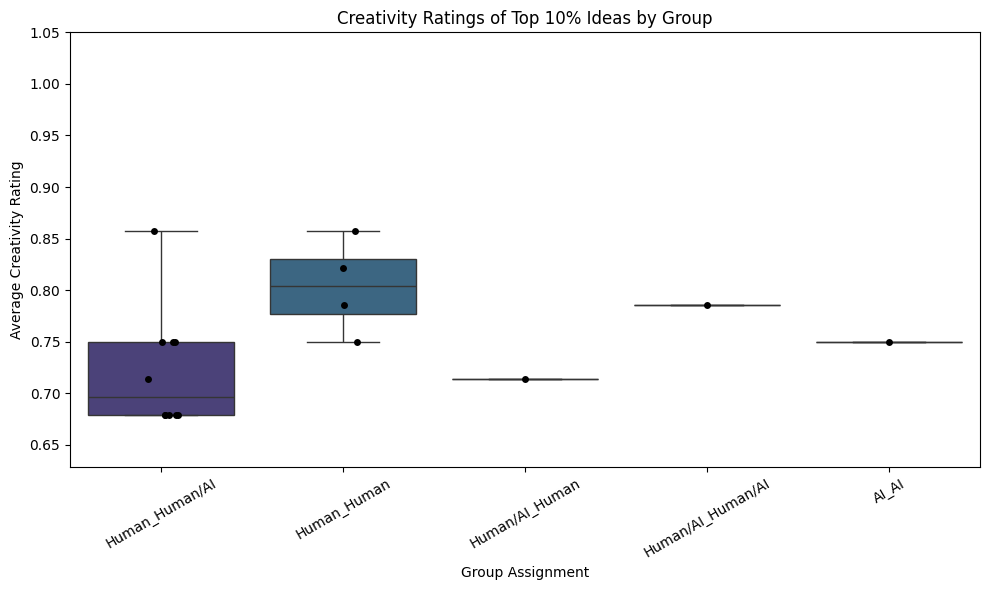

In [38]:
# Drop N/A
df_filtered = df_all_ideas.dropna(subset=["avg_creativity_rating", "GroupAssignment", ])

# calculate threshold for 0.9 quantile
threshold = df_filtered["avg_creativity_rating"].quantile(0.90)

# filter based on threshold
df_top_creative = df_filtered[df_filtered["avg_creativity_rating"] >= threshold]

print("Top 10% Creativity Threshold:", round(threshold, 3))
print(df_top_creative.groupby("GroupAssignment")["avg_creativity_rating"].describe())

# plot number of ideas per group
plt.figure(figsize=(10, 6))
sns.boxplot(x="GroupAssignment", y="avg_creativity_rating", data=df_top_creative, palette="viridis", showfliers=False)
sns.stripplot(x="GroupAssignment", y="avg_creativity_rating", data=df_top_creative, color="black", size=5, jitter=True)
plt.title("Creativity Ratings of Top 10% Ideas by Group")
plt.xlabel("Group Assignment")
plt.ylabel("Average Creativity Rating")
plt.xticks(rotation=30)
plt.ylim(threshold - 0.05, 1.05)
plt.tight_layout()
plt.show()

In [39]:
#display(df_top_creative.sort_values(by='avg_creativity_rating', ascending=False) )

Bottom 10% Creativity Threshold: 0.25
                   count      mean       std       min       25%       50%  \
GroupAssignment                                                              
Human/AI_Human       2.0  0.107143  0.101015  0.035714  0.071429  0.107143   
Human/AI_Human/AI    3.0  0.095238  0.135212  0.000000  0.017857  0.035714   
Human_Human          4.0  0.098214  0.053571  0.071429  0.071429  0.071429   
Human_Human/AI       5.0  0.150000  0.092444  0.035714  0.071429  0.178571   

                        75%       max  
GroupAssignment                        
Human/AI_Human     0.142857  0.178571  
Human/AI_Human/AI  0.142857  0.250000  
Human_Human        0.098214  0.178571  
Human_Human/AI     0.214286  0.250000  


/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_38609/1767842661.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="GroupAssignment", y="avg_creativity_rating", data=df_bottom_creative, palette="viridis", showfliers=False)


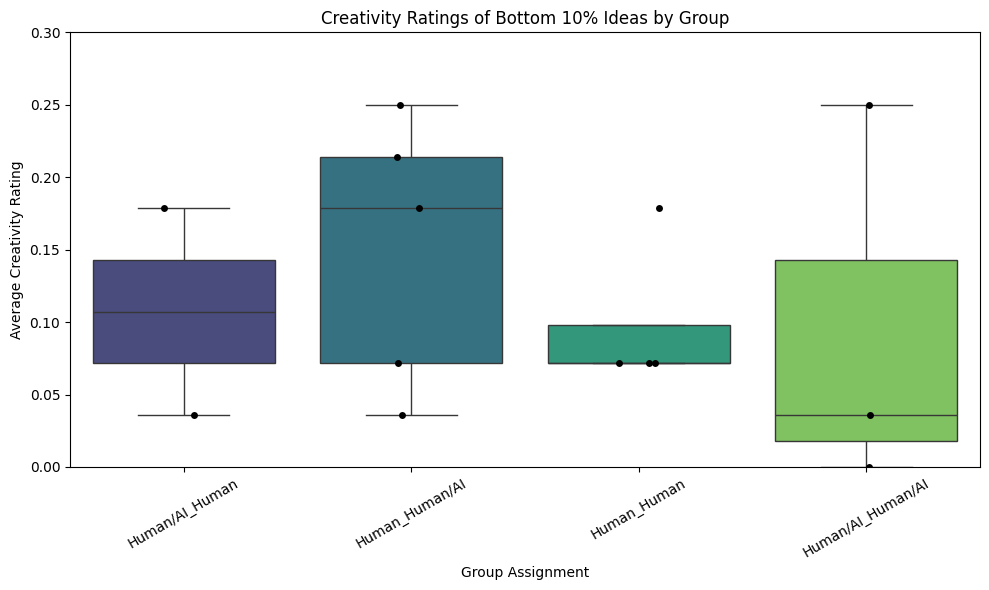

In [40]:
# Drop N/A
df_filtered = df_all_ideas.dropna(subset=["avg_creativity_rating", "GroupAssignment"])

# calculate threshold for 0.1 quantile
threshold = df_filtered["avg_creativity_rating"].quantile(0.10)

# filter based on threshold
df_bottom_creative = df_filtered[df_filtered["avg_creativity_rating"] <= threshold]

print("Bottom 10% Creativity Threshold:", round(threshold, 3))
print(df_bottom_creative.groupby("GroupAssignment")["avg_creativity_rating"].describe())

# Step 4: Plot actual creativity scores per group
plt.figure(figsize=(10, 6))
sns.boxplot(x="GroupAssignment", y="avg_creativity_rating", data=df_bottom_creative, palette="viridis", showfliers=False)
sns.stripplot(x="GroupAssignment", y="avg_creativity_rating", data=df_bottom_creative, color="black", size=5, jitter=True)
plt.title("Creativity Ratings of Bottom 10% Ideas by Group")
plt.xlabel("Group Assignment")
plt.ylabel("Average Creativity Rating")
plt.xticks(rotation=30)
plt.ylim(0, threshold + 0.05)  # focus on bottom range
plt.tight_layout()
plt.show()

In [ ]:
df_all_ideas.to_excel("XXXX/CAT_results_examined.xlsx")

In [51]:
df_all_ideas['IdeaSource_Task1'] = df_all_ideas['GroupAssignment'].apply (lambda x: "Human" if x in ['Human_Human', 'Human_Human/AI'] else "AI" if  x in ['AI_AI'] else "Human/AI" )
df_all_ideas['IdeaSource_Task2'] = df_all_ideas['GroupAssignment'].apply (lambda x: "Human" if x in ['Human_Human', 'Human/AI_Human'] else "AI" if  x in ['AI_AI'] else "Human/AI" )

In [52]:
display(df_all_ideas)

,Idea_ID,avg_creativity_rating,avg_novelty_rating,avg_usefulness_rating,Response ID,idea_elaboration,GroupAssignment,Task1_ChatGPT_Access,Task1_ChatGPT_Interaction,Task2_ChatGPT_Access,...,InnoMgmtExp_High,SustainabilityExp_High,GenAIExp_High,GenAIFrequency_High,Age_35+,Gender_Male,DAT_score_standardized,IdeaSource,IdeaSource_Task2,IdeaSource_Task1
0,R_1VllX72TovsGQQP,0.500000,0.571429,0.500000,R_1VllX72TovsGQQP,Delivery packaging waste is one of the main so...,Human_Human,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,-0.421186,Human,Human,Human
1,R_1qDuAKmI1NSxncV,0.357143,0.357143,0.464286,R_1qDuAKmI1NSxncV,Blue and green roofs. Especially in city’s it ...,Human_Human,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.586911,Human,Human,Human
2,R_20ZHsH9Y3Zhv6Z0,0.392857,0.285714,0.500000,R_20ZHsH9Y3Zhv6Z0,Low-Flow Fixtures: Upgrade to low-flow faucets...,Human_Human/AI,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.514218,Human,Human/AI,Human
3,R_20cuzY5RvsACUOx,0.392857,0.321429,0.607143,R_20cuzY5RvsACUOx,A digital sustainability coach is an AI-based ...,Human/AI_Human,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.407626,Human/AI,Human,Human/AI
4,R_20pCSLhwpy6fYB6,0.678571,0.642857,0.392857,R_20pCSLhwpy6fYB6,Creating a countrywide deposit system for wine...,Human_Human/AI,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.221899,Human,Human/AI,Human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,AI5,0.500000,0.464286,0.642857,NaN,NaN,AI_AI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AI,AI,AI
121,AI6,0.500000,0.535714,0.642857,NaN,NaN,AI_AI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AI,AI,AI
122,AI7,0.500000,0.500000,0.607143,NaN,NaN,AI_AI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AI,AI,AI
123,AI8,0.500000,0.535714,0.607143,NaN,NaN,AI_AI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AI,AI,AI


/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_38609/4096706359.py:26: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:gray'` for the same effect.

  sns.stripplot(data=df_melted, x='IdeaSource_Task1', y='Score', hue='Metric Type',


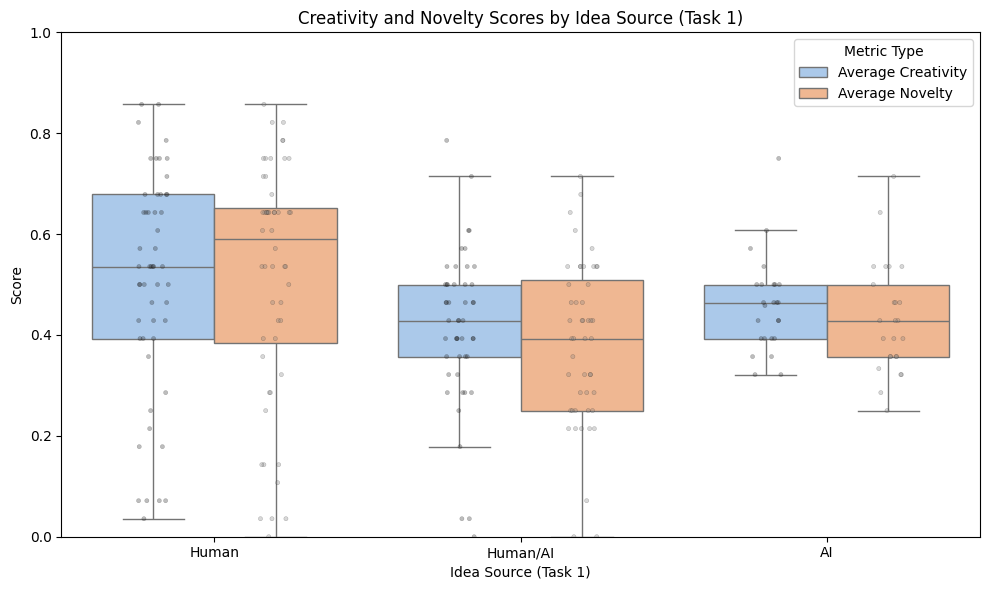

In [55]:
# Reorder idea_source as a categorical variable
category_order = ['Human', 'Human/AI', 'AI']
df_all_ideas['IdeaSource_Task1'] = pd.Categorical(df_all_ideas['IdeaSource_Task1'], categories=category_order, ordered=True)

# Drop N/A values for relevant columns
df_plot = df_all_ideas.dropna(subset=['avg_creativity_rating', 'avg_novelty_rating', 'IdeaSource_Task1'])

# Melt the dataframe to long format
df_melted = df_plot.melt(
    id_vars='IdeaSource_Task1', 
    value_vars=['avg_creativity_rating', 'avg_novelty_rating'],
    var_name='Metric Type', 
    value_name='Score'
)

# Rename the metric labels for the plot
df_melted['Metric Type'] = df_melted['Metric Type'].replace({
    'avg_creativity_rating': 'Average Creativity',
    'avg_novelty_rating': 'Average Novelty'
})

# Plot with spacing and consistent order
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='IdeaSource_Task1', y='Score', hue='Metric Type',
            palette='pastel', showfliers=False, dodge=True)
sns.stripplot(data=df_melted, x='IdeaSource_Task1', y='Score', hue='Metric Type',
              dodge=True, jitter=True, size=3, alpha=0.3, color='gray', edgecolor='black', linewidth=0.3)

# Remove duplicated legend entries
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Metric Type')
plt.title('Creativity and Novelty Scores by Idea Source (Task 1)')
plt.xlabel('Idea Source (Task 1)')
plt.ylabel('Score')
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()


/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_38609/114647099.py:26: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:gray'` for the same effect.

  sns.stripplot(data=df_melted, x='IdeaSource_Task2', y='Score', hue='Metric Type',


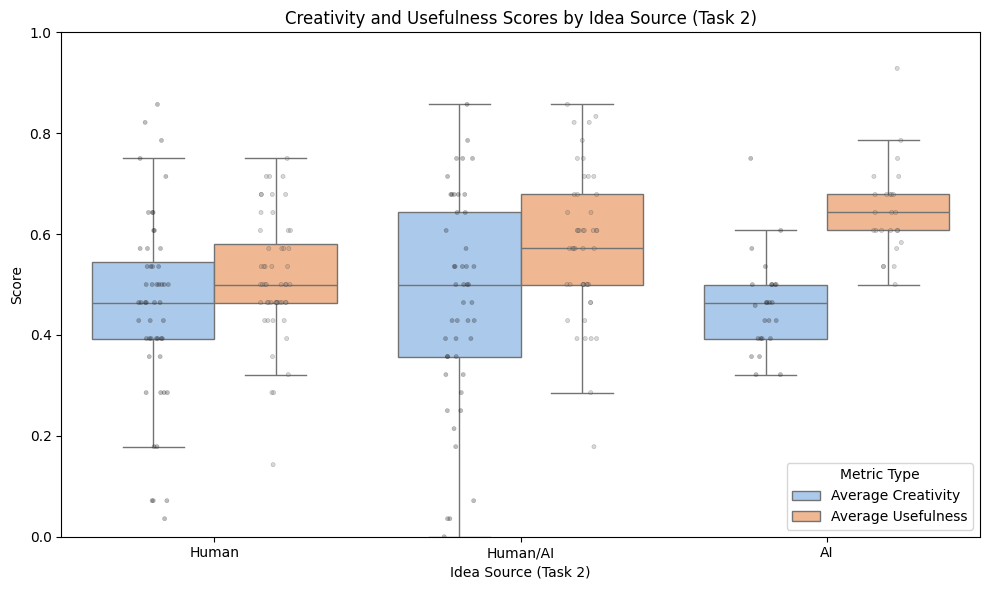

In [56]:
# Reorder idea_source as a categorical variable
category_order = ['Human', 'Human/AI', 'AI']
df_all_ideas['IdeaSource_Task2'] = pd.Categorical(df_all_ideas['IdeaSource_Task2'], categories=category_order, ordered=True)

# Drop N/A values for relevant columns
df_plot = df_all_ideas.dropna(subset=['avg_creativity_rating', 'avg_usefulness_rating', 'IdeaSource_Task1'])

# Melt the dataframe to long format
df_melted = df_plot.melt(
    id_vars='IdeaSource_Task2', 
    value_vars=['avg_creativity_rating', 'avg_usefulness_rating'],
    var_name='Metric Type', 
    value_name='Score'
)

# Rename the metric labels for the plot
df_melted['Metric Type'] = df_melted['Metric Type'].replace({
    'avg_creativity_rating': 'Average Creativity',
    'avg_usefulness_rating': 'Average Usefulness'
})

# Plot with spacing and consistent order
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='IdeaSource_Task2', y='Score', hue='Metric Type',
            palette='pastel', showfliers=False, dodge=True)
sns.stripplot(data=df_melted, x='IdeaSource_Task2', y='Score', hue='Metric Type',
              dodge=True, jitter=True, size=3, alpha=0.3, color='gray', edgecolor='black', linewidth=0.3)

# Remove duplicated legend entries
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Metric Type')
plt.title('Creativity and Usefulness Scores by Idea Source (Task 2)')
plt.xlabel('Idea Source (Task 2)')
plt.ylabel('Score')
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()

/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_38609/3800777448.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='GroupAssignment', y='avg_creativity_rating',


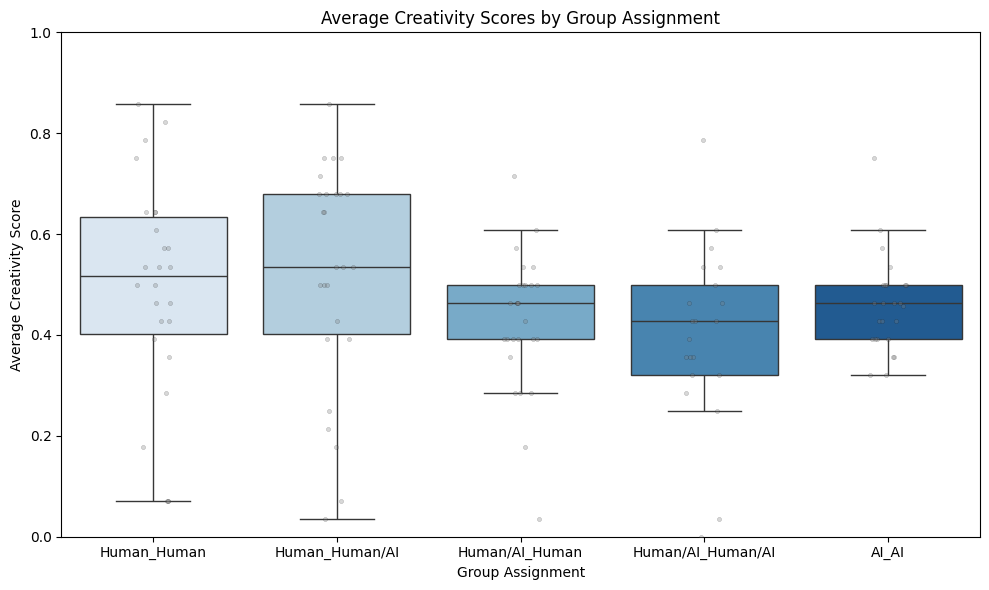

In [ ]:
# Creativity
# drop N/A
df_plot = df_all_ideas.dropna(subset=['avg_creativity_rating', 'GroupAssignment'])

# create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot, x='GroupAssignment', y='avg_creativity_rating', palette='Blues', showfliers=False)
sns.stripplot(data=df_plot, x='GroupAssignment', y='avg_creativity_rating', jitter=True, size=3, alpha=0.3, color='gray', edgecolor='black', linewidth=0.3)
plt.title('Average Creativity Scores by Group Assignment')
plt.xlabel('Group Assignment')
plt.ylabel('Average Creativity Score')
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()


/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_38609/428338037.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='GroupAssignment', y='avg_novelty_rating', palette='Blues', showfliers=False)


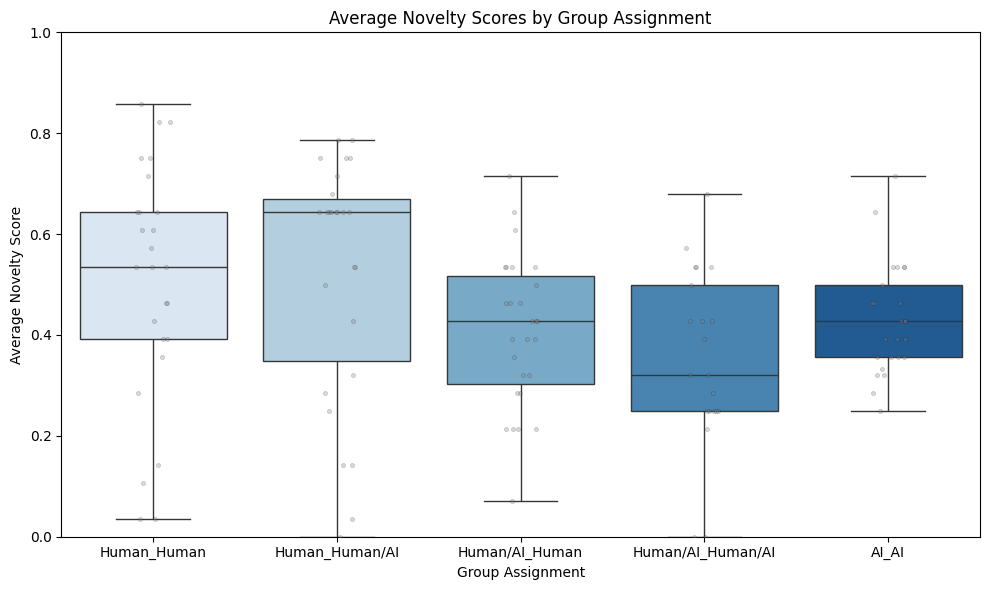

In [63]:
# Novelty
# drop N/A
df_plot = df_all_ideas.dropna(subset=['avg_novelty_rating', 'GroupAssignment'])

# create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot, x='GroupAssignment', y='avg_novelty_rating', palette='Blues', showfliers=False)
sns.stripplot(data=df_plot, x='GroupAssignment', y='avg_novelty_rating', jitter=True, size=3, alpha=0.3, color='gray', edgecolor='black', linewidth=0.3)
plt.title('Average Novelty Scores by Group Assignment')
plt.xlabel('Group Assignment')
plt.ylabel('Average Novelty Score')
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()


/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_38609/391598815.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='GroupAssignment', y='avg_usefulness_rating', palette='Blues', showfliers=False)


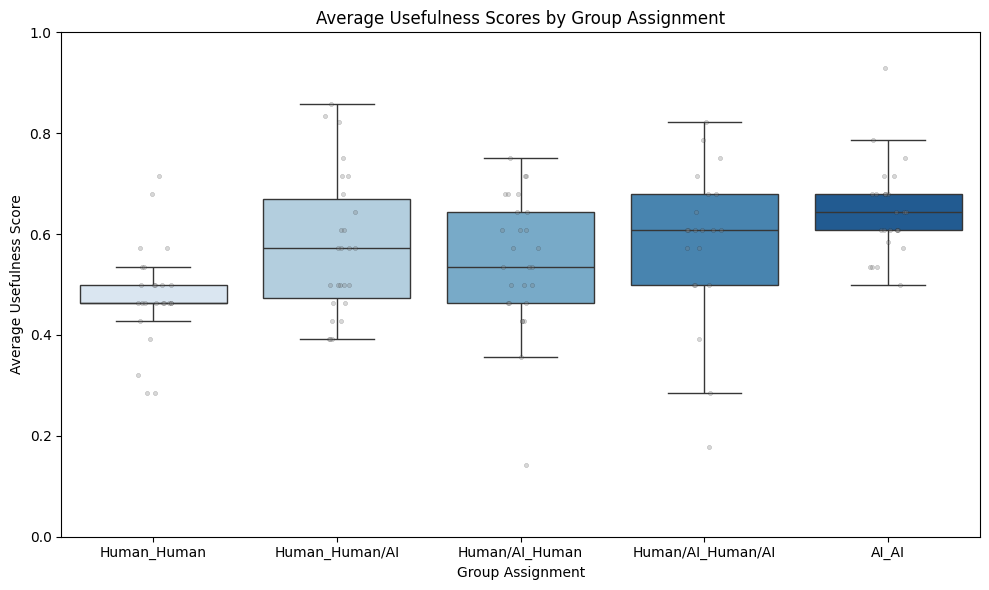

In [64]:
# Usefulness
# drop N/A
df_plot = df_all_ideas.dropna(subset=['avg_usefulness_rating', 'GroupAssignment'])

# create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot, x='GroupAssignment', y='avg_usefulness_rating', palette='Blues', showfliers=False)
sns.stripplot(data=df_plot, x='GroupAssignment', y='avg_usefulness_rating', jitter=True, size=3, alpha=0.3, color='gray', edgecolor='black', linewidth=0.3)
plt.title('Average Usefulness Scores by Group Assignment')
plt.xlabel('Group Assignment')
plt.ylabel('Average Usefulness Score')
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()

In [43]:
display(df_all_ideas)

,Idea_ID,avg_creativity_rating,avg_novelty_rating,avg_usefulness_rating,Response ID,idea_elaboration,GroupAssignment,Task1_ChatGPT_Access,Task1_ChatGPT_Interaction,Task2_ChatGPT_Access,...,BusinessFamiliarity_High,EngExp_High,ProfField_Business,InnoMgmtExp_High,SustainabilityExp_High,GenAIExp_High,GenAIFrequency_High,Age_35+,Gender_Male,DAT_score_standardized
0,R_1VllX72TovsGQQP,0.500000,0.571429,0.500000,R_1VllX72TovsGQQP,Delivery packaging waste is one of the main so...,Human_Human,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,-0.421186
1,R_1qDuAKmI1NSxncV,0.357143,0.357143,0.464286,R_1qDuAKmI1NSxncV,Blue and green roofs. Especially in city’s it ...,Human_Human,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.586911
2,R_20ZHsH9Y3Zhv6Z0,0.392857,0.285714,0.500000,R_20ZHsH9Y3Zhv6Z0,Low-Flow Fixtures: Upgrade to low-flow faucets...,Human_Human/AI,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.514218
3,R_20cuzY5RvsACUOx,0.392857,0.321429,0.607143,R_20cuzY5RvsACUOx,A digital sustainability coach is an AI-based ...,Human/AI_Human,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.407626
4,R_20pCSLhwpy6fYB6,0.678571,0.642857,0.392857,R_20pCSLhwpy6fYB6,Creating a countrywide deposit system for wine...,Human_Human/AI,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.221899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,AI5,0.500000,0.464286,0.642857,NaN,NaN,AI_AI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,AI6,0.500000,0.535714,0.642857,NaN,NaN,AI_AI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,AI7,0.500000,0.500000,0.607143,NaN,NaN,AI_AI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,AI8,0.500000,0.535714,0.607143,NaN,NaN,AI_AI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
print(df_all_ideas['GroupAssignment'].value_counts())

GroupAssignment
Human/AI_Human       27
Human_Human          26
Human_Human/AI       26
AI_AI                25
Human/AI_Human/AI    21
Name: count, dtype: int64
